In [1]:
import glob
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vgg19
import skimage
import skimage.io
import skimage.transform
%matplotlib inline

In [2]:
def load_image(path, height=224, width=224):
    # load image
    img = skimage.io.imread(path)
    img = img / 255.0
    if height is not None and width is not None:
        ny = height
        nx = width
    elif height is not None:
        ny = height
        nx = img.shape[1] * ny / img.shape[0]
    elif width is not None:
        nx = width
        ny = img.shape[0] * nx / img.shape[1]
    else:
        ny = img.shape[0]
        nx = img.shape[1]
    f = skimage.transform.resize(img, (ny, nx)) 
    #image = np.array(f)/225
    image = f.reshape([1,224,224,3])
    image = image.astype('float32')
    return image

In [3]:
def plot_images(content_image, style_image, mixed_image):
   
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    smooth = True
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    content_image = content_image.reshape([224,224,3])
    ax.imshow(content_image, interpolation=interpolation)
    ax.set_xlabel("Content")

    ax = axes.flat[1]
    mixed_image = mixed_image.reshape([224,224,3])
    ax.imshow(mixed_image, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    ax = axes.flat[2]
    style_image = style_image.reshape([224,224,3])
    ax.imshow(style_image, interpolation=interpolation)
    ax.set_xlabel("Style")

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

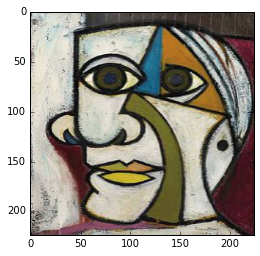

In [4]:
content = load_image('./geyou.jpg')
style = load_image('./style1.jpg')
plt.imshow(style.reshape([224,224,3]))

In [5]:
def mean_squared_error(a,b):
    return tf.reduce_mean(tf.square(a-b))

In [6]:
def gram_matrix(tensor):
    shape = tensor.shape
    num_ch = int(shape[3])
    matrix = tf.reshape(tensor,shape=[-1,num_ch])
    gram = tf.matmul(tf.transpose(matrix),matrix)
    return gram

In [7]:
def get_content (sess,content_input):
   
    
    content_value = sess.run(content_input)
        
    return tf.constant(content_value)

In [8]:
def content_loss(mix_input,content_input):
    #l = layers[layer_id]
    
    return mean_squared_error(mix_input,content_input)

In [9]:
def style_loss(sess,mix_input,style_input):
    mix = gram_matrix(mix_input)
    style = gram_matrix(style_input)
    return mean_squared_error(mix,style)

In [10]:
def denoise_loss(mix_img):
    a = tf.reduce_sum(tf.abs(mix_img[:,1,:,:]-mix_img[:,:-1,:,:]))+tf.reduce_sum(tf.abs(mix_img[:,:,1:,:]-mix_img[:,:,:-1,:]))
    a = tf.cast(a,tf.float32)
    return a

In [11]:
def get_constant(sess,tensor):
    v = sess.run(tensor)
    return tf.constant(v)

# NETWORK

In [12]:
def transfer(content,style,content_weight = 1.5,style_weight = 10,denoise_weight = 0.3,epoches = 100):
    with tf.Session() as sess:
        content_tensor = tf.constant(content,dtype = tf.float32, shape=content.shape)
        style_tensor = tf.constant(style,dtype = tf.float32, shape = style.shape)
        mix_tensor = tf.Variable(content_tensor)
        
        vgg_content = vgg19.Vgg19()      
        with tf.name_scope('vgg_content'):
            vgg_content.build(content_tensor)
            
        vgg_style = vgg19.Vgg19()
        with tf.name_scope('vgg_style'):
            vgg_style.build(style_tensor)
            
        vgg_mix = vgg19.Vgg19()
        with tf.name_scope('vgg_mix'):
            vgg_mix.build(mix_tensor)
            
        with tf.name_scope('cost'):
            #style_cost_3 = style_loss(sess,vgg_mix.conv3_1,vgg_style.conv3_1)
            #style_cost_4 = style_loss(sess,vgg_mix.conv4_1,vgg_style.conv4_1)
            #style_cost_5 = style_loss(sess,vgg_mix.conv5_1,vgg_style.conv5_1)
            
            #mix_layers_style = [vgg_mix.conv1_1, vgg_mix.conv1_2,vgg_mix.conv2_1, vgg_mix.conv2_2,
                         #vgg_mix.conv3_1, vgg_mix.conv3_2,vgg_mix.conv3_3,vgg_mix.conv3_4,
                         #vgg_mix.conv4_1,vgg_mix.conv4_2,vgg_mix.conv4_3,vgg_mix.conv4_4,
                         #vgg_mix.conv5_1,vgg_mix.conv5_2,vgg_mix.conv5_3,vgg_mix.conv5_4]
            #style_layers = [vgg_style.conv1_1, vgg_style.conv1_2,vgg_style.conv2_1, vgg_style.conv2_2,
                         #vgg_style.conv3_1, vgg_style.conv3_2,vgg_style.conv3_3,vgg_style.conv3_4,
                         #vgg_style.conv4_1,vgg_style.conv4_2,vgg_style.conv4_3,vgg_style.conv4_4,
                         #vgg_style.conv5_1,vgg_style.conv5_2,vgg_style.conv5_3,vgg_style.conv5_4]
            mix_layers_style = [vgg_mix.conv3_2,vgg_mix.conv4_4]
            style_layers = [vgg_style.conv3_2,vgg_style.conv4_4]
            style_pool = [get_constant(sess,gram_matrix(v)) for v in style_layers]
            
            total_loss = []
            for i in range(len(style_layers)):
                mix = gram_matrix(mix_layers_style[i])
                style_ = style_pool[i]
                loss = mean_squared_error(mix,style_)
                total_loss.append(loss)
            style_cost = tf.reduce_mean(total_loss)
            #[vgg_content.conv1_1,
            #[vgg_mix.conv1_1,
            content_layer = [vgg_content.conv2_1,vgg_content.conv3_1,
                             vgg_content.conv4_1,vgg_content.conv5_1]
            mix_layer_content = [vgg_mix.conv2_1,vgg_mix.conv3_1,
                                 vgg_mix.conv4_1,vgg_mix.conv5_1]
            content_fix = [get_constant(sess,a) for a in content_layer]
            
            content_loss = []
            for i in range(len(content_layer)):
                mix_content = mix_layer_content[i]
                content_ = content_fix[i]
                loss_ = mean_squared_error(mix_content,content_)
                content_loss.append(loss_)
            content_cost = tf.reduce_mean(content_loss)
            
            #content_cost = mean_squared_error(vgg_mix.conv4_2,content_fix)
            
            denoise_cost = denoise_loss(mix_tensor)
            
            content_cost = content_cost* content_weight
            style_cost = style_cost* style_weight
            denoise_cost = denoise_cost* denoise_weight
            cost = content_cost+style_cost+denoise_cost
            
        
        with tf.name_scope ('train'):
            #g = tf.gradients(cost,mix_tensor)
            #print (g)
            global_step = tf.Variable(0,name='global_step',trainable = False)
            optimizer = tf.train.AdamOptimizer(learning_rate = 0.08)
            grad = optimizer.compute_gradients(cost)
            #with tf.Session() as sess:
            #    print (grad)
            training = optimizer.apply_gradients(grad,global_step = global_step)
            
        with tf.name_scope('output_image'):
            output_image = tf.clip_by_value(tf.squeeze(mix_tensor,[0]),0,1)
            
        sess.run(tf.global_variables_initializer())
        print ('initiated')
        step = 0
        for i in range(epoches):
            #print (denoise_cost.eval(session = sess), style_cost.eval(session = sess),content_cost.eval(session = sess), cost.eval(session = sess))
            img = sess.run(output_image)
            run_list = [global_step,content_cost,style_cost,denoise_cost,cost,training]
            step_out,content_out,style_out,denoise_out,cost_out,_ = sess.run(run_list)
            
            if (i % 5) == 0 or i == epoches-1:
                print ('iterations {} '.format(i))
                print ('content_out: {}, style_out: {} ,denoise_out: {} ,cost_out: {},'.format(content_out,style_out,denoise_out,cost_out))
                plot_images(content_image=content,style_image=style,mixed_image=img)

/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
initiated
iterations 0 
content_out: 0.0, style_out: 12844220.0 ,denoise_out: 2672.436767578125 ,cost_out: 12846892.0,


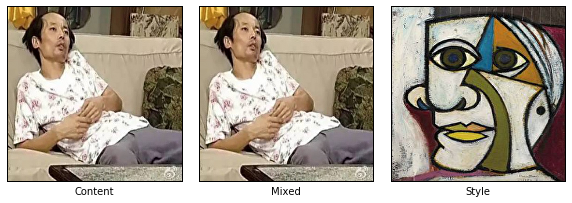

iterations 5 
content_out: 18860.232421875, style_out: 6877544.5 ,denoise_out: 3216.59765625 ,cost_out: 6899621.0,


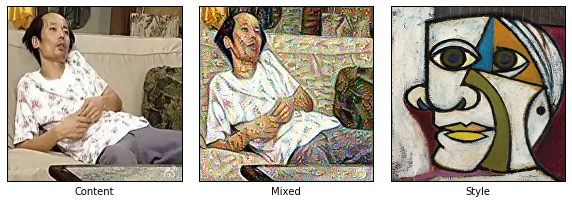

iterations 10 
content_out: 20637.00390625, style_out: 3148892.75 ,denoise_out: 3102.908447265625 ,cost_out: 3172632.75,


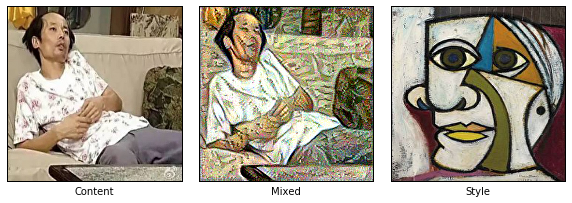

iterations 15 
content_out: 21542.01171875, style_out: 1792043.25 ,denoise_out: 3062.37353515625 ,cost_out: 1816647.625,


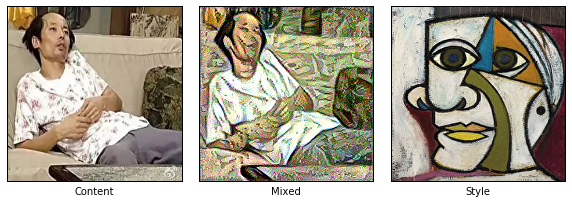

iterations 20 
content_out: 22041.318359375, style_out: 1120419.125 ,denoise_out: 3040.361328125 ,cost_out: 1145500.875,


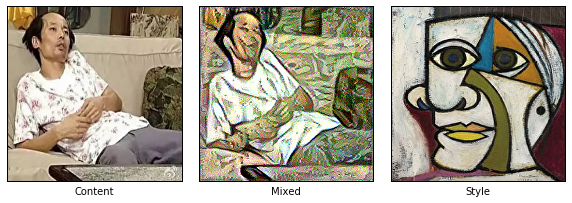

iterations 25 
content_out: 22407.474609375, style_out: 736386.375 ,denoise_out: 3018.552001953125 ,cost_out: 761812.4375,


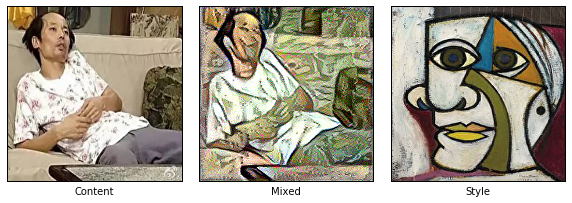

iterations 29 
content_out: 22717.27734375, style_out: 545054.5625 ,denoise_out: 2998.126220703125 ,cost_out: 570769.9375,


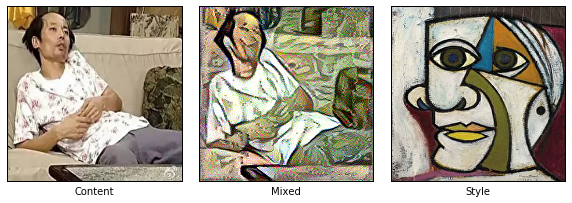

In [13]:
transfer(content,style,content_weight = 1e-1,style_weight = 20e-10,denoise_weight = 0.05,epoches = 30)